In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import time
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data
try:
    from localgraphclustering import *
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    from localgraphclustering import *
    
from affinity_kimon import affinity_multiscale
from affinity_kimon import affinity_gray
from affinity_kimon import affinity
from skimage import data, segmentation, color
from skimage.future import graph
from skimage.segmentation import mark_boundaries

from skimage.color import rgb2gray
from skimage.filters import roberts, sobel, scharr, prewitt

from joblib import Parallel, delayed

import scipy.io as spio

from skimage.io import imread

# from skimage.io import imsave

## Load image from skimage

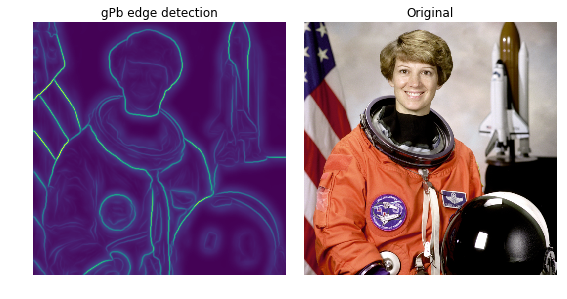

In [2]:
# gPb_orient_101087_small = spio.loadmat('datasets/gPb_orient_101087_small.mat', squeeze_me=True)
gPb_orient_101087_small = spio.loadmat('datasets/gPb_orient_astronaut.mat', squeeze_me=True)

gPb_orient = gPb_orient_101087_small['gPb_orient']

gPb_orient = gPb_orient.max(axis=2)

img = data.astronaut()

img = img/img.max()

[m,n] = img.shape[0:2]
n_pixels = m*n

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 8))

ax[0].imshow(gPb_orient)
ax[1].imshow(img)

ax[0].set_title('gPb edge detection')
ax[1].set_title('Original')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Construct an affinity matrix using our Cython implementation in affinity_kimon. You can replace this with your own adjacency matrix. If you want to use our implementation, please remember to recompile affinity_kimon.pyx under the notebooks folder. Note that this pipeline is not the most efficient for image segmentation. This pipeline uses only colour and position cues. Our objective is to demonstrate how effective local graph clustering is.

In [3]:
# data, row, col = affinity_gray(n_pixels,m,n,5.0,1.0e-5,max(m,n)/1.0e+1,0.001,gPb_orient.astype(float))
# A = sp.sparse.csc_matrix((data, (row, col)), shape=(n_pixels, n_pixels))

A = sp.sparse.load_npz('datasets/A_astronaut.npz')

## Load the matrix in the LocalGraphClustering API

In [4]:
g = GraphLocal()
g.from_sparse_adjacency(A)

## Find a single segment in the image using local graph clustering. Ignore warnings about weighted graphs.

/usr/local/lib/python3.7/site-packages/localgraphclustering/approximate_PageRank.py:119: UserWarning:

The weights of the graph will be discarded. Use approximate_PageRank_weighted or l1reg-rand instead if you want to keep the edge weights.



52.94149613380432
conductance:  0.0006464304926647085


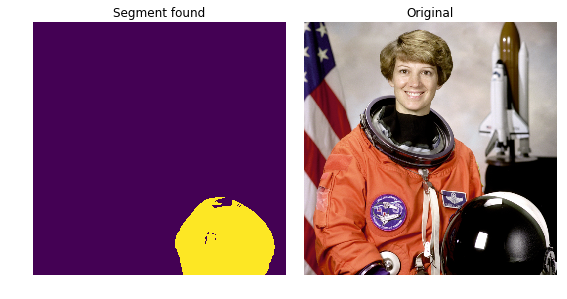

In [5]:
start = time.time()
refnode = [420*n + 390]

nsamples_from_alpha = 50
alpha_list = [1.0e-2,0.3]

sampled_alphas = list(np.geomspace(alpha_list[0], alpha_list[1], nsamples_from_alpha, endpoint=True))

min_crit = 10000
min_crit_embedding = 0

for alpha in list(reversed(sampled_alphas)):

    output = approximate_PageRank(g,refnode,method='l1reg-rand',alpha=alpha,rho=1.0e-15,normalize=False,normalized_objective=False,epsilon=1.0e-2,iterations=1000000) 

    conductance = g.compute_conductance(output[0])

    crit = conductance
    if crit <= min_crit:
        min_crit = crit
        min_crit_embedding = output

end = time.time()
print(end - start)

labels = np.zeros(n_pixels, dtype=np.int32)
labels[min_crit_embedding[0]] = 1

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 8))

ax[0].imshow(labels.reshape((m,n)))
ax[1].imshow(img)

ax[0].set_title('Segment found')
ax[1].set_title('Original')

for a in ax:
    a.axis('off')
    
plt.tight_layout()

print("conductance: ", g.compute_conductance(output[0]))

### Segment the whole image using spectral local graph clustering.

In [15]:
start = time.time()
# Compute the embeddings X and the pairwise distance matrix Z.
labels, info = graph_segmentation(g,rho_list=[1.0e-15,1.0e-1],alpha_list=[1.0e-2,0.3],iterations=1000000,ratio=0.1,nsamples_from_rho=1,nsamples_from_alpha=50,normalized_objective=False,njobs=6,how_many_in_parallel=6)
end = time.time()
print(end - start)

496.6445560455322ted:  90.001678466796882


## Plot

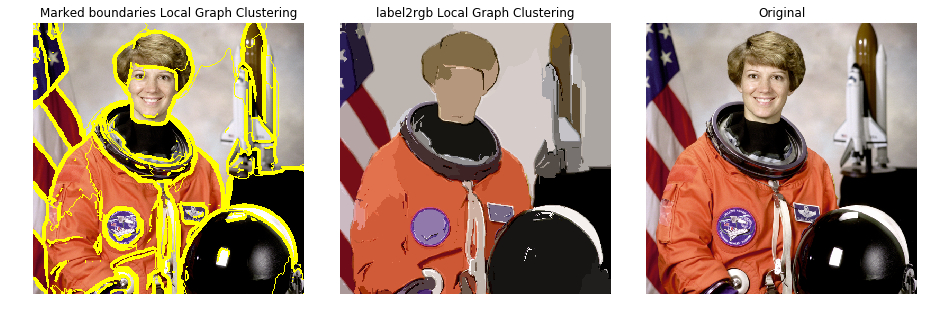

In [16]:
out_lgc = color.label2rgb(labels.reshape((m,n)), img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, labels.reshape((m,n))))
ax[1].imshow(out_lgc)
ax[2].imshow(img)

ax[0].set_title('Marked boundaries Local Graph Clustering')
ax[1].set_title('label2rgb Local Graph Clustering')
ax[2].set_title('Original')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Segment the whole image using spectral + flow (MQI) local graph clustering

In [8]:
start = time.time()
# Compute the embeddings X and the pairwise dis\\tance matrix Z.
labels, info = graph_segmentation_with_improve(g,rho_list=[1.0e-15,1.0e-1],alpha_list=[1.0e-2,0.3],iterations=1000000,ratio=0.1,nsamples_from_rho=1,nsamples_from_alpha=50,normalized_objective=False,njobs=6,how_many_in_parallel=6)
end = time.time()
print(end - start)

629.2967278957367ted:  90.010452270507818


## Visualize the result

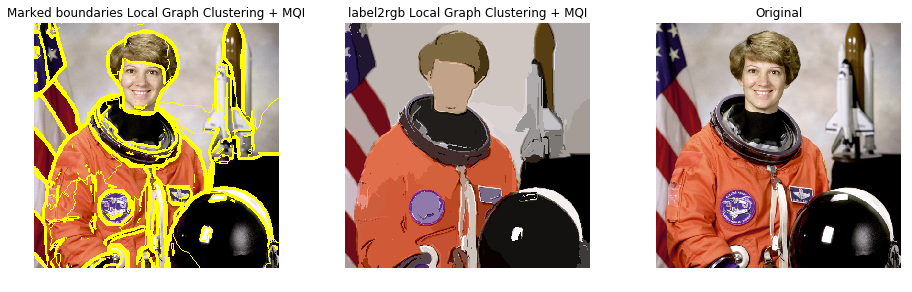

In [9]:
out_lgc_with_improve = color.label2rgb(labels.reshape((m,n)), img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, labels.reshape((m,n))))
ax[1].imshow(out_lgc_with_improve)
ax[2].imshow(img)

ax[0].set_title('Marked boundaries Local Graph Clustering + MQI')
ax[1].set_title('label2rgb Local Graph Clustering + MQI')
ax[2].set_title('Original')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Run the classic normalized cut from skimage

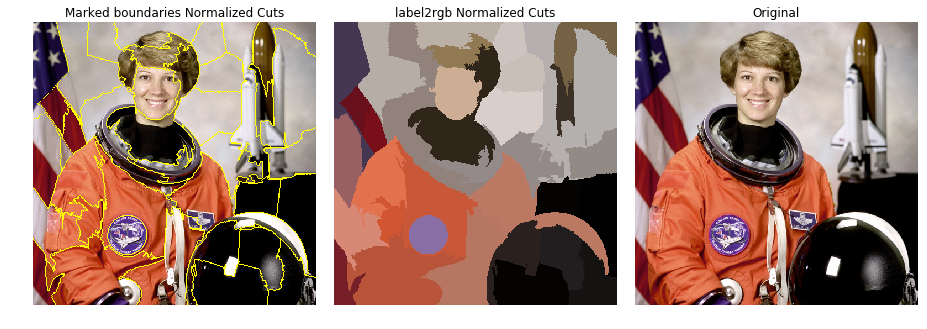

In [10]:
labels_slic = segmentation.slic(img, n_segments=100)
rag_ = graph.rag_mean_color(img, labels_slic, mode='similarity')
new_labels_slic = graph.cut_normalized(labels_slic, rag_, thresh=1, num_cuts=10)
out_ncuts = color.label2rgb(new_labels_slic, img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, new_labels_slic))
ax[1].imshow(out_ncuts)
ax[2].imshow(img)

ax[0].set_title('Marked boundaries Normalized Cuts')
ax[1].set_title('label2rgb Normalized Cuts')
ax[2].set_title('Original')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Slice image using slic from skimage

In [11]:
labels = segmentation.slic(img, compactness=30, n_segments=400)
out_slic = color.label2rgb(labels, img, kind='avg')

## Visualize all results

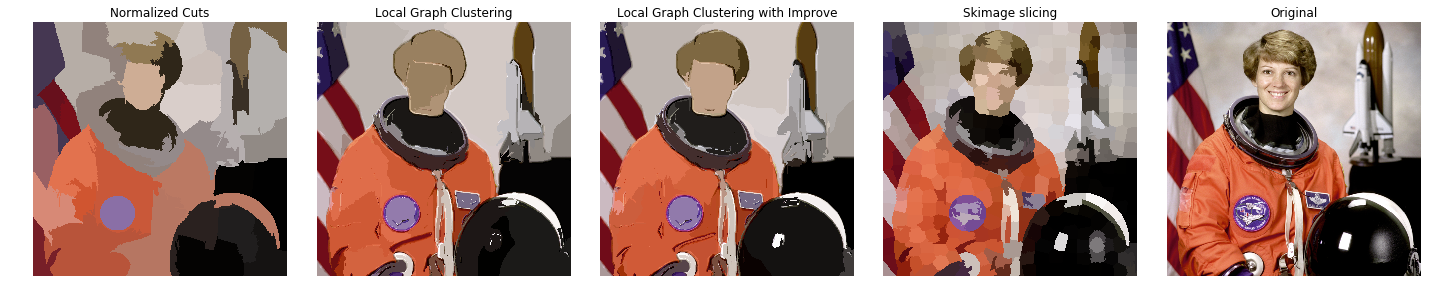

In [12]:
fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(out_ncuts)
ax[1].imshow(out_lgc)
ax[2].imshow(out_lgc_with_improve)
ax[3].imshow(out_slic)
ax[4].imshow(img)

ax[0].set_title('Normalized Cuts')
ax[1].set_title('Local Graph Clustering')
ax[2].set_title('Local Graph Clustering with Improve')
ax[3].set_title('Skimage slicing')
ax[4].set_title('Original')

for a in ax:
    a.axis('off')

plt.tight_layout()

In [13]:
import warnings
warnings.filterwarnings('ignore')

ncp_instance = NCPData(g,store_output_clusters=True,do_largest_component=False)
ncp_instance.approxPageRank(ratio=1,nthreads=6,method = "l1reg-rand")

approxPageRank:ncpapr_l1reg-rand:   78.7 neighborhoods
approxPageRank:ncpapr_l1reg-rand:  125.7 localmin rho=1.0e-05
approxPageRank:ncpapr_l1reg-rand:  171.6 localmin rho=1.0e-04
approxPageRank:ncpapr_l1reg-rand:  323.2 random_node rho=1.0e-05
approxPageRank:ncpapr_l1reg-rand:  475.7 random_node rho=1.0e-04
approxPageRank:ncpapr_l1reg-rand:  628.1 random_neighborhood rho=1.0e-05
approxPageRank:ncpapr_l1reg-rand:  780.7 random_neighborhood rho=1.0e-04


## Make an interactive NCP

In [14]:
p = NCPPlots(ncp_instance)
p.cond_by_size_itrv();